## --------------------------
## Get data
## --------------------------

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns

processedDataStorePath = '../processed_data/'

X_train_labeled = np.load(processedDataStorePath+'X_train_labeled.npy')
y_train_labeled = np.load(processedDataStorePath+'y_train_labeled.npy')
X_trainA_labeled = np.load(processedDataStorePath+'X_trainA_labeled.npy')
# y_trainA_labeled = np.load(processedDataStorePath+'y_trainA_labeled.npy')
X_trainB_labeled = np.load(processedDataStorePath+'X_trainB_labeled.npy')
# y_trainB_labeled = np.load(processedDataStorePath+'y_trainB_labeled.npy')
X_train_unlabeled = np.load(processedDataStorePath+'X_train_unlabeled.npy')
X_test = np.load(processedDataStorePath+'X_test.npy')
y_test = np.load(processedDataStorePath+'y_test.npy')

unique, counts = np.unique(y_train_labeled, return_counts=True)
print('for train labeled data: \n', np.asarray((unique, counts)).T) 

unique, counts = np.unique(y_test, return_counts=True)
print('for test data: \n', np.asarray((unique, counts)).T) 

def printDatasetShape():
    print('X_train_labeled: ',X_train_labeled.shape,'  X_train_unlabeled: ',X_train_unlabeled.shape,'  X_test: ',X_test.shape)

printDatasetShape()

for train labeled data: 
 [[ 0 13]
 [ 1  8]]
for test data: 
 [[ 0 13]
 [ 1  8]]
X_train_labeled:  (21, 16)   X_train_unlabeled:  (188, 16)   X_test:  (21, 16)


## --------------------------
## Split features
## --------------------------

In [2]:
fa = [1, 3, 5, 7, 9, 11, 12, 13] # feature A, refer to data_process.ipynb
fb = [0, 2, 4, 6, 8, 10, 14, 15]

def splitFeatures(dataSet, featureList):
    return (dataSet.T[featureList]).T

X_testA = splitFeatures(X_test, fa)
X_testB = splitFeatures(X_test, fb)
X_trainA_unlabeled = splitFeatures(X_train_unlabeled, fa)
X_trainB_unlabeled = splitFeatures(X_train_unlabeled, fb)

## --------------------------
## Testing
## --------------------------

In [3]:
part=10
start=5

import xgboost as xgb
from sklearn.metrics import classification_report, confusion_matrix  
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import random

def testXGBoost(X_train,y_train,X_test,y_test):
    
    dtrain = xgb.DMatrix(data = X_train, label = y_train)
#     Dval = xgb.DMatrix(data=X_val, label=y_val)
    Dtest = xgb.DMatrix(data = X_test, label = y_test)
    
    param = {'max_depth': 3, 'eta': 1, 'silent': 1, 'objective': 'binary:logistic','estimators':10,'eval_metric':'auc'}

#     evallist = [(Dval, 'eval')]
    evallist = [(dtrain, 'train')]
    plst = param.items()

    num_round = 10

    bst = xgb.train(plst, dtrain, num_round, evallist, early_stopping_rounds=5)#, verbose_eval=50)
    y_pred_score = bst.predict(Dtest)
    y_pred = [round(value) for value in y_pred_score]

    print(confusion_matrix(y_test,y_pred),'\n')
    print(accuracy_score(y_test,y_pred),'\n')
    
    return bst,accuracy_score(y_test,y_pred)

In [4]:
bstA,accA = testXGBoost(X_trainA_labeled[start:part+start],y_train_labeled[start:part+start],X_testA,y_test)


[0]	train-auc:0.928571
Will train until train-auc hasn't improved in 5 rounds.
[1]	train-auc:0.928571
[2]	train-auc:0.928571
[3]	train-auc:0.928571
[4]	train-auc:0.928571
[5]	train-auc:0.928571
Stopping. Best iteration:
[0]	train-auc:0.928571

[[11  2]
 [ 1  7]] 

0.8571428571428571 



In [5]:
bstB,accB = testXGBoost(X_trainB_labeled[start:part+start],y_train_labeled[start:part+start],X_testB,y_test)


[0]	train-auc:0.928571
Will train until train-auc hasn't improved in 5 rounds.
[1]	train-auc:0.928571
[2]	train-auc:0.928571
[3]	train-auc:0.928571
[4]	train-auc:0.928571
[5]	train-auc:0.928571
Stopping. Best iteration:
[0]	train-auc:0.928571

[[9 4]
 [1 7]] 

0.7619047619047619 



In [6]:

bst,acc = testXGBoost(X_train_labeled[start:part+start],y_train_labeled[start:part+start],X_test,y_test)



[0]	train-auc:0.928571
Will train until train-auc hasn't improved in 5 rounds.
[1]	train-auc:0.928571
[2]	train-auc:0.928571
[3]	train-auc:0.928571
[4]	train-auc:0.928571
[5]	train-auc:0.928571
Stopping. Best iteration:
[0]	train-auc:0.928571

[[9 4]
 [1 7]] 

0.7619047619047619 



### self training

In [7]:
import heapq

# return all with same highest confidence
def getIndexWithHighConfidence(data,p):
    print('=========================================')
    print('=========================================')
    largestList=[]
    smallestList=[]
    largestValue = heapq.nlargest(1,data)[0]
    print('largest value: ', largestValue)
    smallestValue = heapq.nsmallest(1,data)[0]
    print('smallest value: ', smallestValue)
    if largestValue>.7:
        largestList = [idx for idx, val in enumerate(data) if abs(val-largestValue)<=p]
#         if (len(largestList)>num):
#             random.shuffle(largestList)
#             largestList=largestList[:num]
    print('len of largest list: ', len(largestList))
    if smallestValue<.3:
        smallestList = [idx for idx, val in enumerate(data) if abs(val-smallestValue)<=p]
#         if (len(smallestList)>num):
#             random.shuffle(smallestList)
#             smallestList=smallestList[:num]
    print('len of smallest list: ', len(smallestList))
    indexList = largestList + smallestList

    print('=========================================')
    print('=========================================')
    
    indexList.sort()
    indexList.reverse()
    return indexList

In [8]:
# prob = 0.001
# a=getIndexWithHighConfidence(
#     bst.predict(xgb.DMatrix(data=X_train_unlabeled, 
#     label=[1 for i in range(len(X_train_unlabeled))])),
#     prob,10)


[0]	train-auc:0.928571
Will train until train-auc hasn't improved in 5 rounds.
[1]	train-auc:0.928571
[2]	train-auc:0.928571
[3]	train-auc:0.928571
[4]	train-auc:0.928571
[5]	train-auc:0.928571
Stopping. Best iteration:
[0]	train-auc:0.928571

[[9 4]
 [1 7]] 

0.7619047619047619 

largest value:  0.51088256
smallest value:  0.1602374
len of largest list:  0
len of smallest list:  82
number of newly added:  82
[0]	train-auc:0.994382
Will train until train-auc hasn't improved in 5 rounds.
[1]	train-auc:1
[2]	train-auc:1
[3]	train-auc:1
[4]	train-auc:1
[5]	train-auc:1
[6]	train-auc:1
Stopping. Best iteration:
[1]	train-auc:1

[[13  0]
 [ 1  7]] 

0.9523809523809523 

largest value:  0.6913926
smallest value:  0.050879672
len of largest list:  0
len of smallest list:  3
number of newly added:  3
[0]	train-auc:0.978261
Will train until train-auc hasn't improved in 5 rounds.
[1]	train-auc:1
[2]	train-auc:1
[3]	train-auc:1
[4]	train-auc:1
[5]	train-auc:1
[6]	train-auc:1
Stopping. Best iterati

/Users/heyuhao/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:3358: RuntimeWarning: Second argument 'y' is ambiguous: could be a color spec but is in data; using as data.  Either rename the entry in data or use three arguments to plot.
  ret = ax.plot(*args, **kwargs)


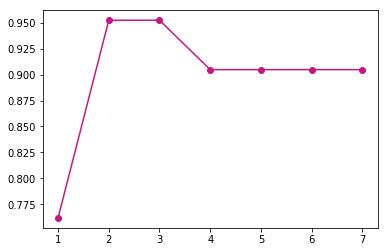

In [9]:
# bst=testXGBoost(X_train,y_train,X_val,y_val,X_test,y_test)
from matplotlib import pyplot as plt
def drawLine(data):
    dataRange = [i for i in range(1,len(data)+1)]
    df = pd.DataFrame({'x':dataRange, 'y':data})
    plt.plot( 'x', 'y', data=df, marker='o', color='mediumvioletred')
    plt.show()
    
    
def selfTraining(X_train_labeled,y_train_labeled,X_test,y_test,X_train_unlabeled):

    accuracy=[]
    prob = 0.002

    bst,acc = testXGBoost(X_train_labeled,y_train_labeled,X_test,y_test)
    accuracy.append(acc)

    try:
        for i in range(100):
            y_pseudo_score = bst.predict(xgb.DMatrix(data=X_train_unlabeled, label=[1 for i in range(len(X_train_unlabeled))]))
            y_pseudo = np.array(list(map(int,[np.round(i) for i in y_pseudo_score])))

            X_new=[]
            y_new=[]

            for index in getIndexWithHighConfidence(y_pseudo_score,prob):
                X_new.append(X_train_unlabeled[index])
                y_new.append(y_pseudo[index])
                X_train_unlabeled=np.delete(X_train_unlabeled,index,0) # 0 is row

            X_new=np.array(X_new)
            y_new=np.array(y_new)
            print('number of newly added: ',len(y_new))

            X_train_labeled = np.concatenate((X_train_labeled,X_new),axis=0)
            y_train_labeled = np.concatenate((y_train_labeled,y_new),axis=0)

            if i%10==0:
                prob=prob*1.5


            bst,acc = testXGBoost(X_train_labeled,y_train_labeled,X_test,y_test)
            accuracy.append(acc)
    
    except:
        pass
    
    finally:
        drawLine(accuracy)

selfTraining(X_train_labeled[start:part+start],y_train_labeled[start:part+start],X_test,y_test,X_train_unlabeled)

In [10]:
printDatasetShape()

X_train_labeled:  (21, 16)   X_train_unlabeled:  (188, 16)   X_test:  (21, 16)


### co training

[0]	train-auc:0.928571
Will train until train-auc hasn't improved in 5 rounds.
[1]	train-auc:0.928571
[2]	train-auc:0.928571
[3]	train-auc:0.928571
[4]	train-auc:0.928571
[5]	train-auc:0.928571
Stopping. Best iteration:
[0]	train-auc:0.928571

[[11  2]
 [ 1  7]] 

0.8571428571428571 

[0]	train-auc:0.928571
Will train until train-auc hasn't improved in 5 rounds.
[1]	train-auc:0.928571
[2]	train-auc:0.928571
[3]	train-auc:0.928571
[4]	train-auc:0.928571
[5]	train-auc:0.928571
Stopping. Best iteration:
[0]	train-auc:0.928571

[[9 4]
 [1 7]] 

0.7619047619047619 

largest value:  0.51088256
smallest value:  0.1602374
len of largest list:  0
len of smallest list:  94
largest value:  0.51088256
smallest value:  0.1602374
len of largest list:  0
len of smallest list:  82
number of newly added:  80
[0]	train-auc:0.994253
Will train until train-auc hasn't improved in 5 rounds.
[1]	train-auc:1
[2]	train-auc:1
[3]	train-auc:1
[4]	train-auc:1
[5]	train-auc:1
[6]	train-auc:1
Stopping. Best iterati

/Users/heyuhao/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:3358: RuntimeWarning: Second argument 'y' is ambiguous: could be a color spec but is in data; using as data.  Either rename the entry in data or use three arguments to plot.
  ret = ax.plot(*args, **kwargs)


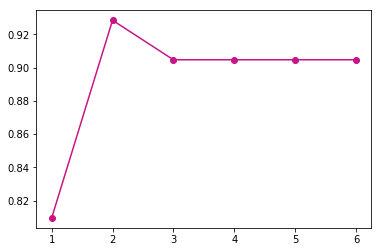

ValueError: all the input arrays must have same number of dimensions

In [12]:
# bst=testXGBoost(X_train,y_train,X_val,y_val,X_test,y_test)
from matplotlib import pyplot as plt
def drawLine(data):
    dataRange = [i for i in range(1,len(data)+1)]
    df = pd.DataFrame({'x':dataRange, 'y':data})
    plt.plot( 'x', 'y', data=df, marker='o', color='mediumvioletred')
    plt.show()
    
    
def coTraining(X_trainA_labeled,X_trainB_labeled,y_train_labeled,X_testA,X_testB,y_test,X_trainA_unlabeled,X_trainB_unlabeled):
    
    fa = [1, 3, 5, 7, 9, 11, 12, 13] # feature A, refer to data_process.ipynb
    fb = [0, 2, 4, 6, 8, 10, 14, 15]
    
    accuracy=[]
    prob = 0.002

    bstA,accA = testXGBoost(X_trainA_labeled,y_train_labeled,X_testA,y_test)
    bstB,accB = testXGBoost(X_trainB_labeled,y_train_labeled,X_testB,y_test)
    
    accuracy.append((accA+accB)/2)

    try:
        for i in range(100):
            yA_pseudo_score = bstA.predict(xgb.DMatrix(data=X_trainA_unlabeled, label=[1 for i in range(len(X_trainA_unlabeled))]))
            yB_pseudo_score = bstB.predict(xgb.DMatrix(data=X_trainB_unlabeled, label=[1 for i in range(len(X_trainB_unlabeled))]))
            yA_pseudo = np.array(list(map(int,[np.round(i) for i in yA_pseudo_score])))

            highConfidenceIndexA = getIndexWithHighConfidence(yA_pseudo_score,prob)
            highConfidenceIndexB = getIndexWithHighConfidence(yB_pseudo_score,prob)
        
            highConfidenceIndexA.extend(highConfidenceIndexB)
            highConfidenceIndex = list(set(highConfidenceIndexA))
            
            # agree
            highConfidenceIndex = [index for index in highConfidenceIndex if np.round(yA_pseudo_score[index])==np.round(yB_pseudo_score[index])]
            highConfidenceIndex.sort()
            highConfidenceIndex.reverse()
            
            X_newA=[]
            X_newB=[]
            y_new=[]
            
            for index in highConfidenceIndex: 
                X_newA.append(X_trainA_unlabeled[index])
                X_newB.append(X_trainB_unlabeled[index])
                y_new.append(yA_pseudo[index])
                X_trainA_unlabeled=np.delete(X_trainA_unlabeled,index,0) # 0 is row
                X_trainB_unlabeled=np.delete(X_trainB_unlabeled,index,0)
                
            X_newA=np.array(X_newA)
            X_newB=np.array(X_newB)
            y_new=np.array(y_new)
            
            print('number of newly added: ',len(y_new))

            X_trainA_labeled = np.concatenate((X_trainA_labeled,X_newA),axis=0)
            X_trainB_labeled = np.concatenate((X_trainB_labeled,X_newB),axis=0)
            y_train_labeled = np.concatenate((y_train_labeled,y_new),axis=0)

            if i%10==0:
                prob=prob*1.5


            bstA,accA = testXGBoost(X_trainA_labeled,y_train_labeled,X_testA,y_test)
            bstB,accB = testXGBoost(X_trainB_labeled,y_train_labeled,X_testB,y_test)

            accuracy.append((accA+accB)/2)
            
    except:
        pass
    
    finally:
        drawLine(accuracy)

coTraining(X_trainA_labeled[start:part+start],X_trainB_labeled[start:part+start],y_train_labeled[start:part+start],X_testA,X_testB,y_test,X_trainA_unlabeled,X_trainB_unlabeled)

